## PART 1:

In this part of the mini-project, we use NinaPro Dataset 1 (https://ninapro.hevs.ch/instructions/DB1.html) to classify and predict the movement classes associated to the different EMG signals for a single subject. Participants are tasked  to replicate the movement shown on the screen. Surface EMG signals are recorded while the  participants perform the tasks.  

Articles:

- Atzori et al., "Characterization of a Benchmark Database for Myoelectric Movement Classification," in IEEE Transactions on Neural Systems and Rehabilitation Engineering, vol. 23, no. 1, pp. 73-83, Jan. 2015, doi: 10.1109/TNSRE.2014.2328495.

- Atzori, M., Gijsberts, A., Castellini, C., Caputo, B., Hager, A., Elsig, S., Giatsidis, G., Bassetto, F., & Müller, H. (2014). Electromyography data for non-invasive naturally-controlled robotic hand prostheses. Scientific Data, 1(1), 140053. https://doi.org/10.1038/sdata.2014.53


Method: Here we are concerned with Surface electromyography (sEMG). The sEMG data are acquired using 10 Otto Bock MyoBock 13E200 electrodes, while kinematic data are acquired using a Cyberglove 2 data glove. The sampling rate on sEMG is 100 Hz.

The data comes from S2: Intact (this is, non amputee)	Right Handed	Male	27	years old

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.integrate import simpson  
import pandas as pd

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.integrate import simpson




### 1. Preprocess and Visualize

In [2]:
data = loadmat("./s2/S2_A1_E1.mat")
#data = loadmat("C:/Users/kslif/NSSP_Project2_TeamP/s2[1]/S2_A1_E1.mat")

In [3]:
print(f"What kind of data structure are we working with? {type(data)}")
print(f"What are the keys of the data structure? {[key for key in data.keys()]}") 

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


#### 1a. Review Data

Question 1: Visualize and preprocess the data for subject 2 (use only the first exercise set:  S2_A1_E1 with 12 actions). Does the data look reasonable? Did you need to remove  any trials?  

Sampling frequency: 100 Hz, the standard Ninapro DB1 protocol (Otto Bock sensors)


In [4]:
#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement

#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 


emg_rectified = data["emg"].copy()
print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [5]:
# Number of movements, repetitions and channels in this data set:
n_stimuli = len(np.unique(stimulus)) - 1  # -1 because 0 is the resting condition
n_repetitions = len(np.unique(repetition)) - 1  # -1 because 0 is not a repetition
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}')
print(f'How many channels are there? {n_channels}')

How many types of movement are there? 12
How many repetitions are there? 10
How many channels are there? 10


In [6]:
#Duration of trials (i.e. number of samples within a repetition of a stimulus):

number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

Check rectification

   - No need for rectification

In [7]:
# Check if the EMG is rectified

def check_rectification(emg):
    total_vals = emg.size
    negative_vals = np.sum(emg < 0)
    percent_negative = 100 * negative_vals / total_vals
    
    print(f"Total samples: {total_vals}")
    print(f"Negative samples: {negative_vals} ({percent_negative:.4f}%)")
    
    if percent_negative < 0.01:  # less than 0.01% negative values
        print("EMG is likely rectified")
    else:
        print("EMG is not rectified (raw bipolar signal)")

# Run it on your data
check_rectification(emg_rectified)

Total samples: 1006860
Negative samples: 0 (0.0000%)
EMG is likely rectified


Check EMG spectrum

- No need of notch filtering -- no visible peak at 50Hz
- From the paper, the sampling rate was 100Hz
- Seemingly no need for bandpass filtering

In [8]:
print(emg_rectified.shape)

(100686, 10)


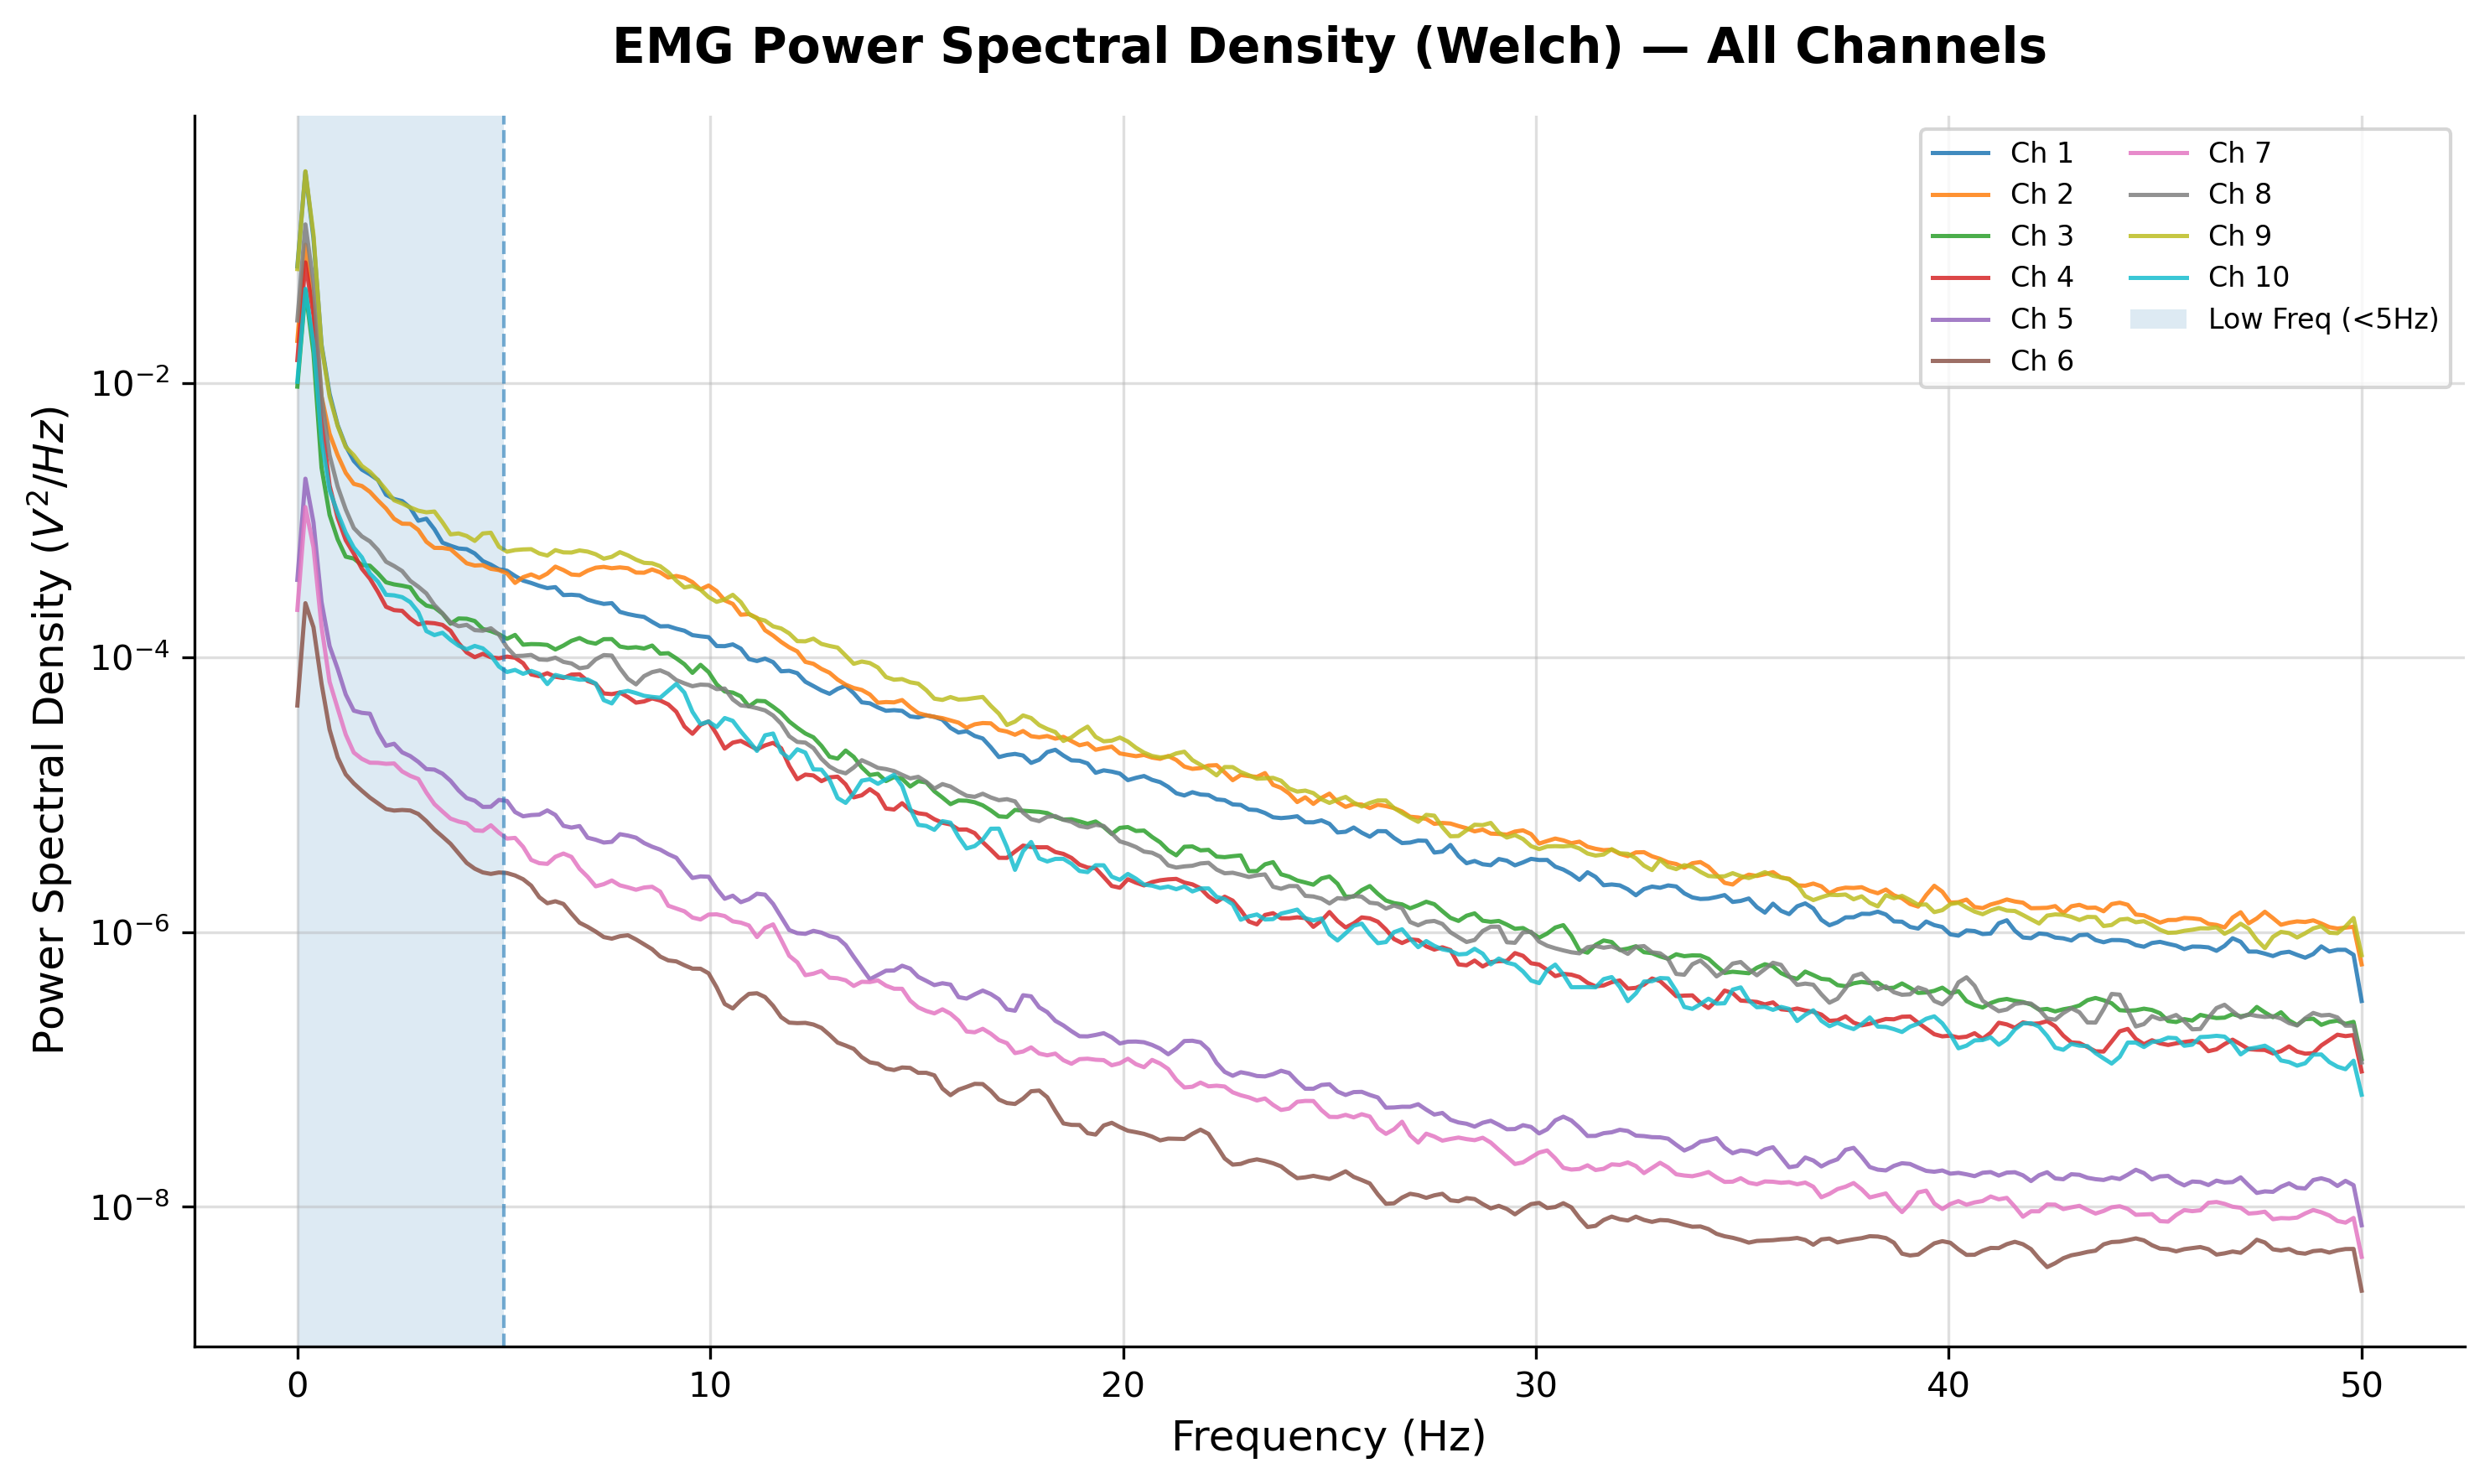

In [9]:

def plot_emg_spectrum_all_channels(emg_rectified, fs=100, low_freq_cutoff=5, nperseg=512):
    emg_rectified = np.asarray(emg_rectified)
    if emg_rectified.ndim != 2:
        raise ValueError(f"emg_rectified must be 2D (timepoints, channels). Got shape {emg_rectified.shape}")

    n_time, n_ch = emg_rectified.shape
    if n_time < 4:
        raise ValueError("Signal too short to compute Welch PSD.")
    nperseg_eff = min(nperseg, n_time)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    for ch in range(n_ch):
        x = emg_rectified[:, ch]
        f, Pxx = welch(x, fs=fs, nperseg=nperseg_eff)
        ax.semilogy(f, Pxx, lw=1.2, alpha=0.85, label=f"Ch {ch+1}")

    ax.axvspan(0, low_freq_cutoff, alpha=0.15, label=f"Low Freq (<{low_freq_cutoff}Hz)")
    ax.axvline(low_freq_cutoff, linestyle="--", alpha=0.6, lw=1)

    ax.set_title("EMG Power Spectral Density (Welch) — All Channels", fontsize=14, fontweight="bold", pad=15)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel(r"Power Spectral Density ($V^2/Hz$)", fontsize=12)

    ax.grid(True, which="major", ls="-", alpha=0.4)
    ax.grid(True, which="minor", ls=":", alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(loc="upper right", frameon=True, fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

plot_emg_spectrum_all_channels(emg_rectified, fs=100, low_freq_cutoff=5, nperseg=512)


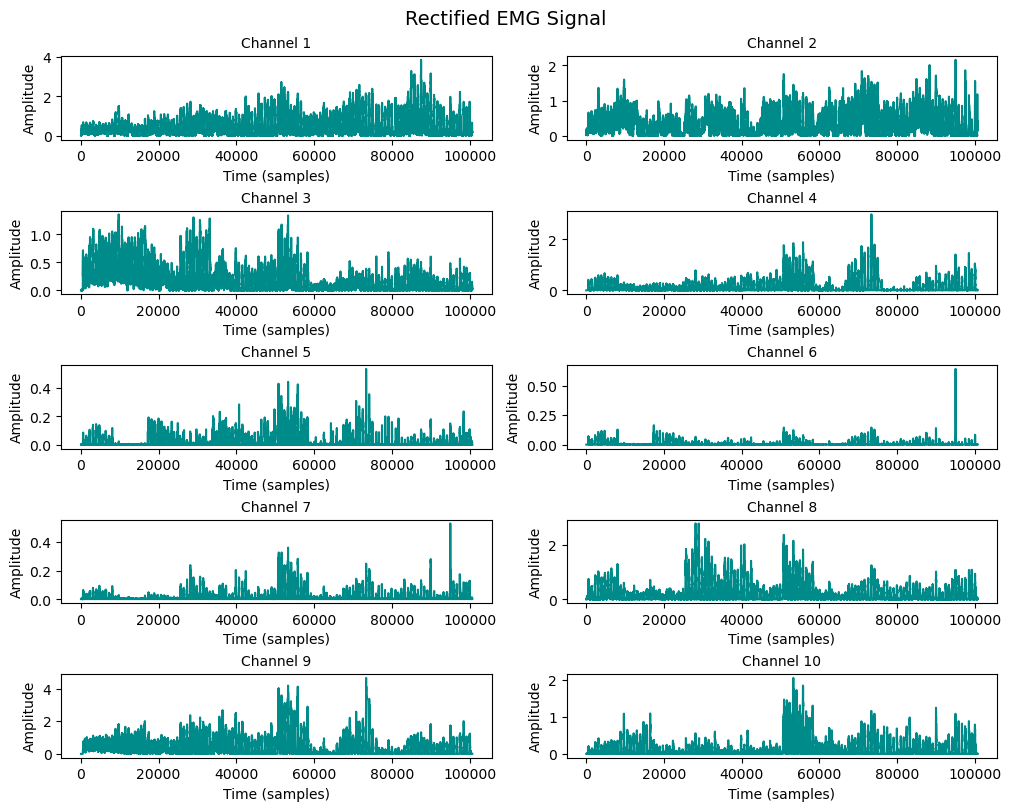

In [10]:
number_of_emg_channels = emg_rectified.shape[-1]
fig, ax = plt.subplots(5, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()  
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_rectified[:, channel_idx], color="darkcyan" )
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}", fontsize=10)
    ax[channel_idx].set_xlabel("Time (samples)")
    ax[channel_idx].set_ylabel("Amplitude")

fig.suptitle("Rectified EMG Signal", fontsize=14)
plt.show()

In [11]:
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
import numpy as np

def view_trial(stimulus_id=1, repetition_id=1):
    idx = np.logical_and(stimulus == stimulus_id, repetition == repetition_id).flatten()
    trial = emg_rectified[idx, :]

    if trial is None or trial.size == 0:
        print(f"No data found for Stimulus {stimulus_id}, Repetition {repetition_id}")
        return
    n_ch = trial.shape[1]
    y_max = np.max(trial)
    y_max = max(y_max * 1.1, 0.05)

    fig, axes = plt.subplots(5, 2, figsize=(10, 10), constrained_layout=True)
    axes = axes.ravel()

    for ch in range(n_ch):
        axes[ch].plot(trial[:, ch], linewidth=1, color="darkcyan")
        axes[ch].set_title(f"Ch {ch+1}", fontsize=10)
        axes[ch].set_ylim(0, y_max)
        axes[ch].grid(True, alpha=0.3)
        axes[ch].set_xlabel("Time (samples)")
        axes[ch].set_ylabel("Amplitude")

    for k in range(n_ch, len(axes)):
        axes[k].axis("off")

    fig.suptitle(f"Rectified EMG | Stimulus {stimulus_id} | Repetition {repetition_id}", fontsize=14)
    plt.show()

print("Use the sliders to loop through your data:")
interact(
    view_trial,
    stimulus_id=IntSlider(min=1, max=n_stimuli, step=1, value=1),
    repetition_id=IntSlider(min=1, max=n_repetitions, step=1, value=1),
)

Use the sliders to loop through your data:


interactive(children=(IntSlider(value=1, description='stimulus_id', max=12, min=1), IntSlider(value=1, descrip…

<function __main__.view_trial(stimulus_id=1, repetition_id=1)>

### Preprocessing:

In [12]:
import numpy as np
from scipy.signal import butter, filtfilt

# 1 Hz low-pass Butterworth 
def lowpass_1hz(x, fs=100, order=1):
    x = np.asarray(x)
    b, a = butter(order, 1 / (fs / 2), btype='low')
    return filtfilt(b, a, x)

# Moving average smoothing 
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length  # Average of 25 neighbors
fs = 100  # Ninapro sampling frequency

# rectified
emg_rect_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

# rectified + moving average
emg_ma_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

# rectified + 1 Hz Butterworth
emg_lp_1hz = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

rectified_emg = data["emg"].copy()

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(
            stimulus == stimuli_idx + 1,
            repetition == repetition_idx + 1
        ).flatten()
        
        current_window = rectified_emg[idx, :]
        
        if current_window.size == 0:
            continue  

        emg_rect_windows[stimuli_idx][repetition_idx] = current_window
        envelope_ma = np.array([
            np.convolve(current_window[:, ch], mov_mean_weights, mode="same")
            for ch in range(current_window.shape[1])]).T  
        emg_ma_envelopes[stimuli_idx][repetition_idx] = envelope_ma

        env_1hz = np.zeros_like(current_window)
        for ch in range(current_window.shape[1]):
            env_1hz[:, ch] = lowpass_1hz(current_window[:, ch], fs=fs)
        emg_lp_1hz[stimuli_idx][repetition_idx] = env_1hz


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_emg_versions(
    s, r, ch,
    emg_rect_windows,
    emg_ma_envelopes,
    emg_lp_1hz,
    stimulus=None):
    
    raw = emg_rect_windows[s][r][:, ch]
    ma  = emg_ma_envelopes[s][r][:, ch]
    lp1 = emg_lp_1hz[s][r][:, ch]

    T = len(raw)
    x = np.arange(T)

    colors = {
        "raw": "#f1b6da", 
        "ma":  "#8c96c6",   
        "lp1": "#4d004b"}

    plt.figure(figsize=(12, 6))

    plt.plot(x, raw, label="Raw (Rectified)", color=colors["raw"], linewidth=2.2, alpha=0.8)
    plt.plot(x, ma,  label="Moving Average (25 samples)", color=colors["ma"], linewidth=2.5)
    plt.plot(x, lp1, label="1 Hz Butterworth Filter", color=colors["lp1"], linewidth=2.5)

    title = f"EMG Signal Comparison — Stim {s+1}, Rep {r+1}, Channel {ch+1}"
    
    if stimulus is not None:
        try:
            title += f" — Gesture: {stimulus[s][r]}"
        except:
            pass

    plt.title(title, fontsize=14, weight="bold", color=colors["lp1"])
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.25)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


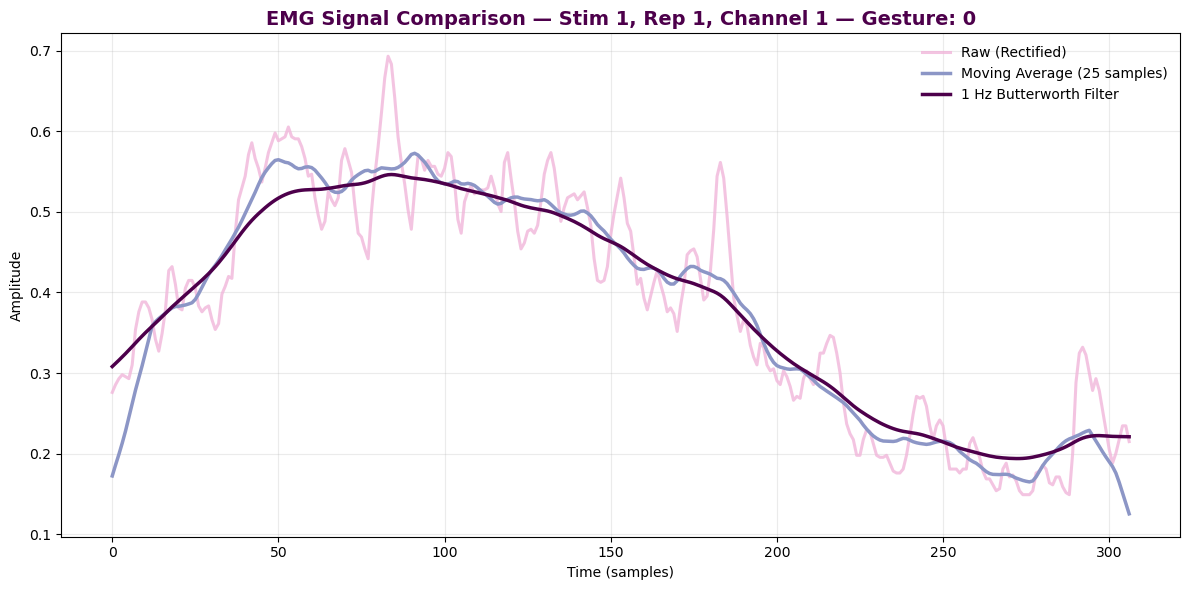

In [14]:
visualize_emg_versions(
    s=0,
    r=0,
    ch=0,
    emg_rect_windows=emg_rect_windows,
    emg_ma_envelopes=emg_ma_envelopes,
    emg_lp_1hz=emg_lp_1hz,
    stimulus=stimulus
)


### 2. Feature Selection

Question 3: Extract features from the trials (at least 5 different ones), explain briefly why you picked these features. 
 

In [15]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    n_samples = n_stimuli * n_repetitions
    
    n_channels = emg.shape[1]
    n_features = sum(n_channels for feature in features)
    
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            labels[current_sample_index] = i + 1
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            for feature in features:
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                current_feature_index += n_channels
            current_sample_index += 1
            
    return dataset, labels

In [16]:
#defining features

# https://www.nature.com/articles/sdata201453#Sec10 and Hudgins et al. 

# 1. Root mean square (RMS) 
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# 2. Mean absolute value (MAV) 
mav = lambda x: np.mean(np.abs(x), axis=0)

# Not using zero crossings bc data has been rectified

# 3. Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# 4.  Slope sign changes (SSC) 
ssc = lambda x: np.sum(
    np.diff(x, axis=0)[:-1] * np.diff(x, axis=0)[1:] < 0,
    axis=0
)

# 5 Marginal DWT per channel (sym4, 3 levels)  
import pywt

def feat_mdwt_total(x, wavelet="sym4", level=3):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]

    n_ch = x.shape[1]
    out = np.zeros(n_ch, dtype=float)

    w = pywt.Wavelet(wavelet)

    for ch in range(n_ch):
        sig = x[:, ch]
        max_level = pywt.dwt_max_level(len(sig), w.dec_len)
        use_level = min(level, max_level)

        coeffs = pywt.wavedec(sig, wavelet, level=use_level)
        out[ch] = np.sum([np.sum(np.abs(c)) for c in coeffs])  # sum across subbands

    return out

mdwt = lambda x, wavelet="sym4", level=3: feat_mdwt_total(x, wavelet=wavelet, level=level)


# # 6. Histogram of log amplitude per channel (20 bins) 
def feat_hist_log_entropy(x, bins=20):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, None]

    n_ch = x.shape[1]
    out = np.zeros(n_ch, dtype=float)

    for ch in range(n_ch):
        sig = np.log10(np.abs(x[:, ch]) + 1e-12)
        hist, _ = np.histogram(sig, bins=bins, density=True)

        p = hist / (np.sum(hist) + 1e-12)          # normalize
        out[ch] = -np.sum(p * np.log(p + 1e-12))   # Shannon entropy

    return out

hist_log = lambda x, bins=20: feat_hist_log_entropy(x, bins=bins)


# 7.  Variance of EMG (VAR) 
var_ = lambda x: np.var(x, axis=0)
    
# 8. Integrated EMG (IEMG)  
iemg = lambda x: np.sum(np.abs(x), axis=0)

# 9. Willison Amplitude (WAMP) 
def wamp(x, threshold=0.01):
    # x: (timepoints, channels)
    return np.sum(np.abs(np.diff(x, axis=0)) > threshold, axis=0)
wamp_feat = lambda x: wamp(x, threshold=0.01)

#10. Power Spectral Density (PSD)
def PSD(x, fs=100, nperseg=None):                        
    x = np.atleast_2d(x)
    if x.shape[0] < x.shape[1]:  
        x = x.T
    if nperseg is None:
        nperseg = min(256, x.shape[0]) 
    freqs, psd_vals = welch(x, fs=fs, nperseg=nperseg, axis=0)
    return freqs, psd_vals
psd = lambda x: np.mean(PSD(x)[1], axis=0)



In [17]:
dataset, labels = build_dataset_from_ninapro(
    emg=emg_rectified,
    stimulus=stimulus,
    repetition=repetition,
    features=[
        rms,
        mav,
        wl,
        ssc,
        iemg,
        var_,
        wamp_feat,       
        hist_log,
        mdwt,
        psd
    ]
)


In [18]:
print(dataset.shape)

(120, 100)


### 3. Data Visualization: 

#### Across different trials: Compare values over repetitions of the same gesture (Intra-class stability of features)

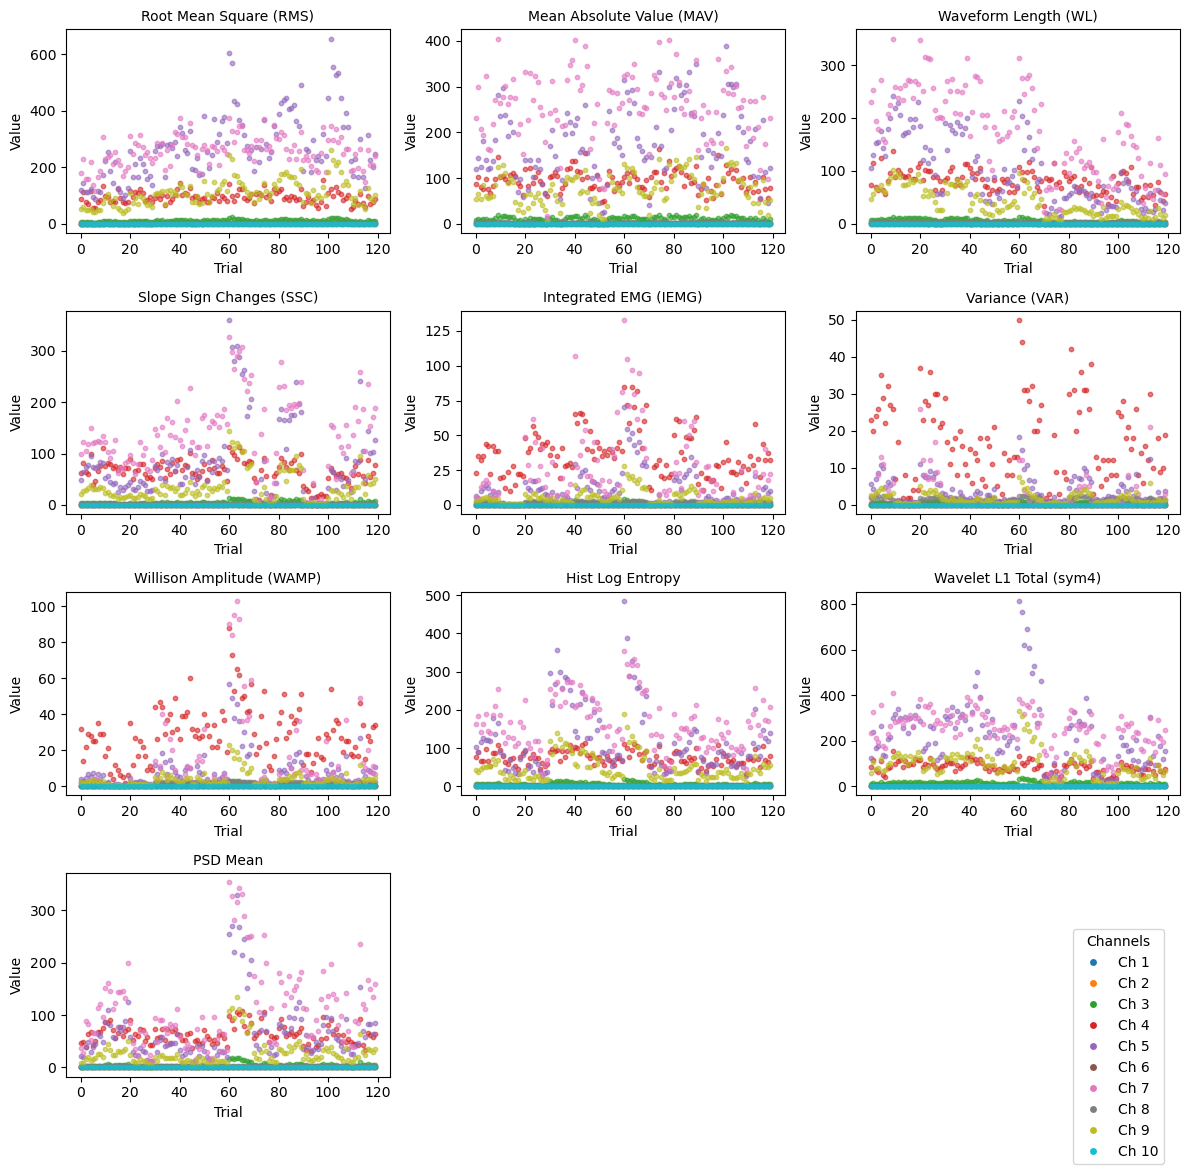

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D

n_trials, n_total_features = dataset.shape
n_channels = 10

assert n_total_features % n_channels == 0, (
    f"Total features ({n_total_features}) is not divisible by n_channels ({n_channels}). "
    "Check n_channels or how dataset was built."
)
n_features = n_total_features // n_channels

feature_names = [
    "Root Mean Square (RMS)",
    "Mean Absolute Value (MAV)",
    "Waveform Length (WL)",
    "Slope Sign Changes (SSC)",
    "Integrated EMG (IEMG)",
    "Variance (VAR)",
    "Willison Amplitude (WAMP)",
    "Hist Log Entropy",
    "Wavelet L1 Total (sym4)",
    "PSD Mean"
]

assert len(feature_names) == n_features, (
    f"feature_names has {len(feature_names)} names but dataset implies {n_features} features/channel."
)

dataset_reshaped = dataset.reshape(n_trials, n_channels, n_features)

colors = plt.cm.tab10(np.arange(n_channels))

ncols = 3
nrows = 4

fig = plt.figure(figsize=(4 * ncols, 3 * nrows))

for f in range(n_features):
    ax = plt.subplot(nrows, ncols, f + 1)
    for ch in range(n_channels):
        ax.scatter(
            np.arange(n_trials),
            dataset_reshaped[:, ch, f],
            color=colors[ch],
            alpha=0.6,
            s=10
        )
    ax.set_title(feature_names[f], fontsize=10)
    ax.set_xlabel("Trial")
    ax.set_ylabel("Value")

legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[ch], markersize=6,
           label=f"Ch {ch+1}")
    for ch in range(n_channels)
]

fig.legend(
    handles=legend_handles,
    loc="lower right",
    bbox_to_anchor=(0.98, 0.02),
    frameon=True,
    title="Channels"
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


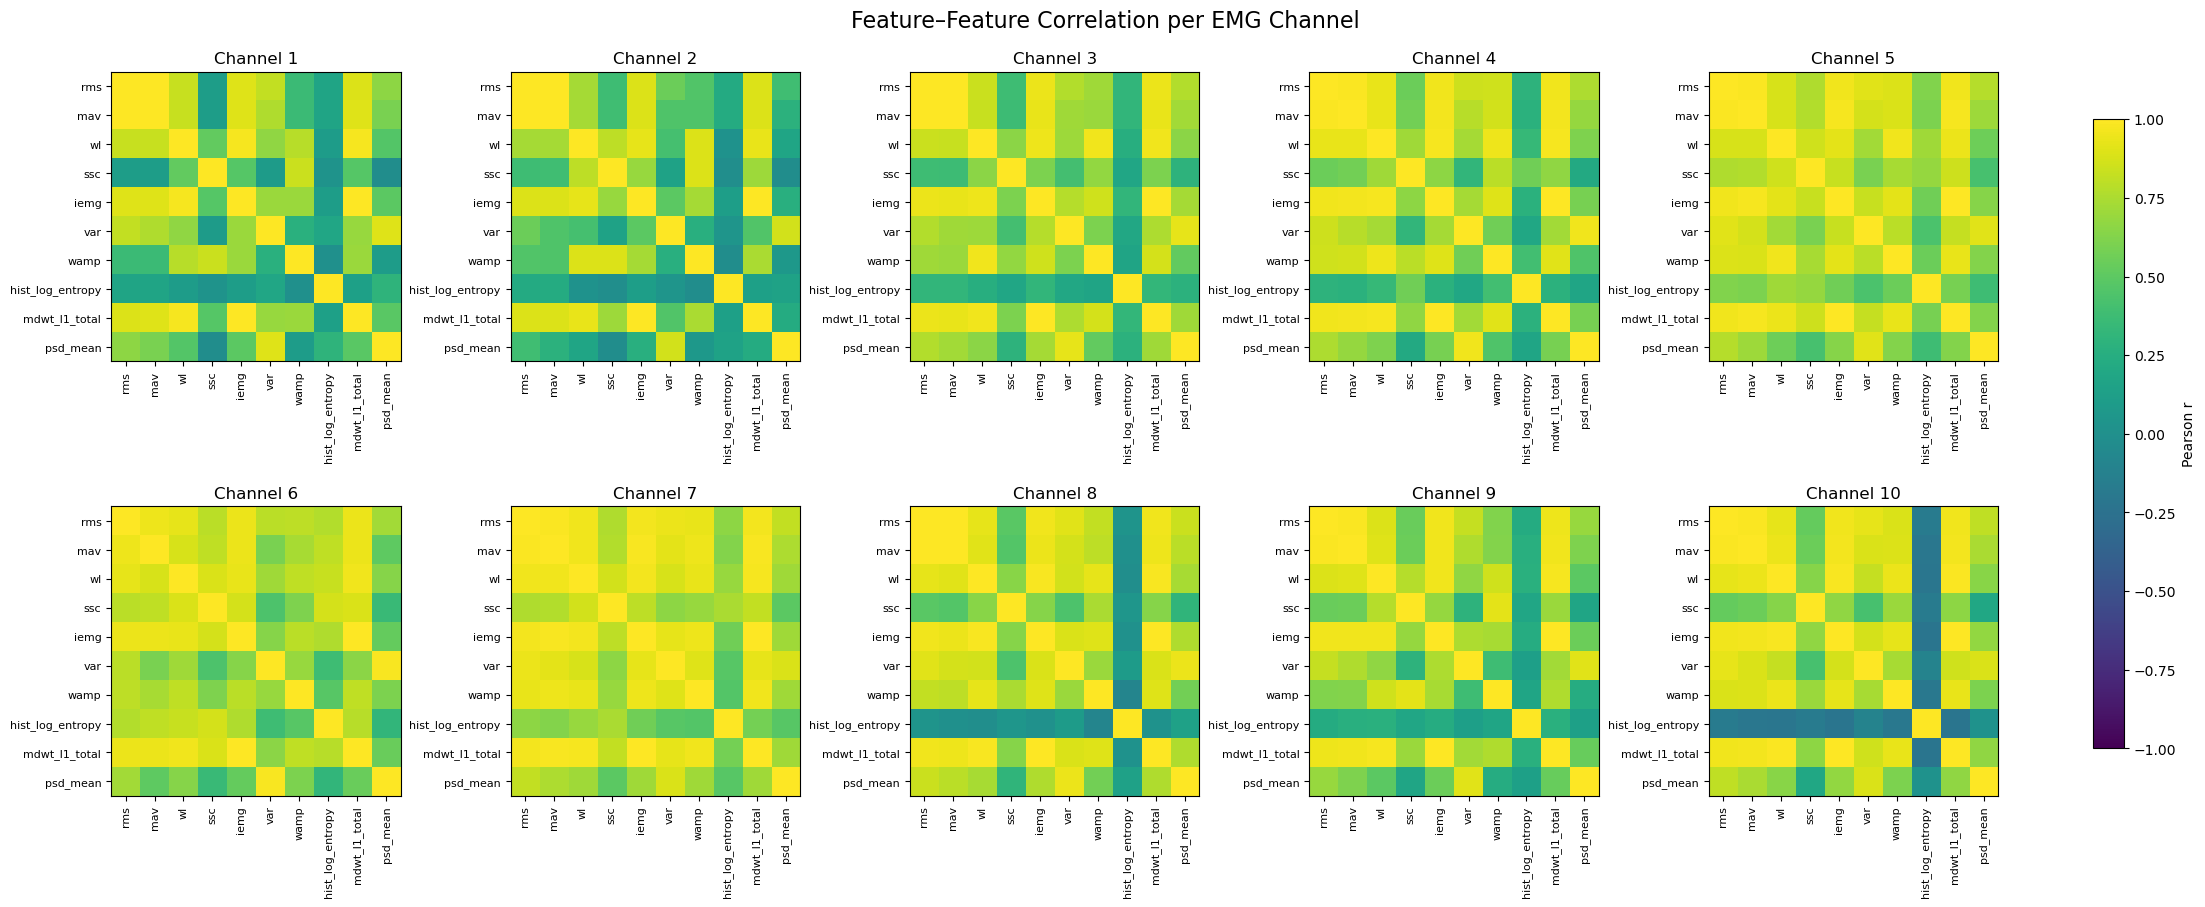

In [20]:
import numpy as np
import matplotlib.pyplot as plt

n_trials, n_total = dataset.shape
n_channels = 10

assert n_total % n_channels == 0, (
    f"Got n_total={n_total}, which is not divisible by n_channels={n_channels}."
)
n_features = n_total // n_channels


data = dataset.reshape(n_trials, n_features, n_channels)
data = np.transpose(data, (0, 2, 1))  

feature_names = [
    "rms", "mav", "wl", "ssc", "iemg", "var", "wamp",
    "hist_log_entropy", "mdwt_l1_total", "psd_mean"]

assert len(feature_names) == n_features, (
    f"feature_names has {len(feature_names)} names but dataset implies {n_features} features/channel."
)

ncols, nrows = 5, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(22, 9), constrained_layout=True)
axes = axes.ravel()

for ch in range(n_channels):
    X = data[:, ch, :]                
    corr = np.corrcoef(X, rowvar=False)

    ax = axes[ch]
    im = ax.imshow(corr, vmin=-1, vmax=1)
    ax.set_title(f"Channel {ch+1}", fontsize=12)

    ax.set_xticks(np.arange(n_features))
    ax.set_yticks(np.arange(n_features))
    ax.set_xticklabels(feature_names, rotation=90, fontsize=8)
    ax.set_yticklabels(feature_names, fontsize=8)

cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.8)
cbar.set_label("Pearson r", rotation=90)

fig.suptitle("Feature–Feature Correlation per EMG Channel", fontsize=16)
plt.show()


### 4. Split

Question 2: Split the data into training, validation, and testing sets for the subject. Why do we need  the different datasets?  

In [21]:
def balanced_split(dataset, labels, seed=None):
    """
    Balanced train/val/test split with labels.

    Per stimulus:
      - 7 train
      - 2 validation
      - 1 test

    Parameters
    ----------
    dataset : np.ndarray
        Shape (120, 100)
    labels : np.ndarray
        Shape (120,)
    seed : int or None
        Random seed for reproducibility

    Returns
    -------
    X_train, y_train
    X_val, y_val
    X_test, y_test
    """
    rng = np.random.default_rng(seed)

    n_stimuli = 12
    reps_per_stimulus = 10

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for stim in range(n_stimuli):
        start = stim * reps_per_stimulus
        end = start + reps_per_stimulus

        X_stim = dataset[start:end]
        y_stim = labels[start:end]

        idx = rng.permutation(reps_per_stimulus)

        val_idx = idx[:2]
        test_idx = idx[2:3]
        train_idx = idx[3:]

        X_val.append(X_stim[val_idx])
        y_val.append(y_stim[val_idx])

        X_test.append(X_stim[test_idx])
        y_test.append(y_stim[test_idx])

        X_train.append(X_stim[train_idx])
        y_train.append(y_stim[train_idx])

    # Stack splits
    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)
    X_val   = np.vstack(X_val)
    y_val   = np.concatenate(y_val)
    X_test  = np.vstack(X_test)
    y_test  = np.concatenate(y_test)

    # Shuffle each split independently
    def shuffle_split(X, y):
        p = rng.permutation(len(y))
        return X[p], y[p]

    X_train, y_train = shuffle_split(X_train, y_train)
    X_val, y_val     = shuffle_split(X_val, y_val)
    X_test, y_test   = shuffle_split(X_test, y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [22]:
print(dataset.shape)
print(labels.shape)

(120, 100)
(120,)


In [23]:
X_train, y_train, X_val, y_val, X_test, y_test = balanced_split(
    dataset=dataset,
    labels=labels,
    seed=42
)

In [24]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (84, 100)
Validation set shape: (24, 100)
Test set shape: (12, 100)


In [25]:
print(f"Train labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

Train labels shape: (84,)
Validation labels shape: (24,)
Test labels shape: (12,)


### 6. Classify

Question 4:  Perform classification on the data of subject 2. Predict the action of the subject based  on the EMG signals. Use hyperparameter optimization to increase your models’  performance. You will use one of the algorithm families throughout the whole project  (meaning for part 1, 2 and 3) depending on your project variant.  

Project variant 1: Support Vector Machine

In [26]:
from sklearn.svm import SVC  # Import SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.exceptions import UndefinedMetricWarning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

warnings.filterwarnings("ignore", category=UserWarning)

In [27]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_val_z = scaler.transform(X_val)        
X_test_z = scaler.transform(X_test)       


Hyperparameter optimisation:

In [28]:
# Define parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernels
    'degree': [3, 4, 5]                     # Degree for 'poly' kernel
}

grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring='accuracy',   
    cv=5,                
    n_jobs=-1,           
    verbose=1
)

grid_search.fit(X_train_z, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation Accuracy score: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}
Best cross-validation Accuracy score: 0.905


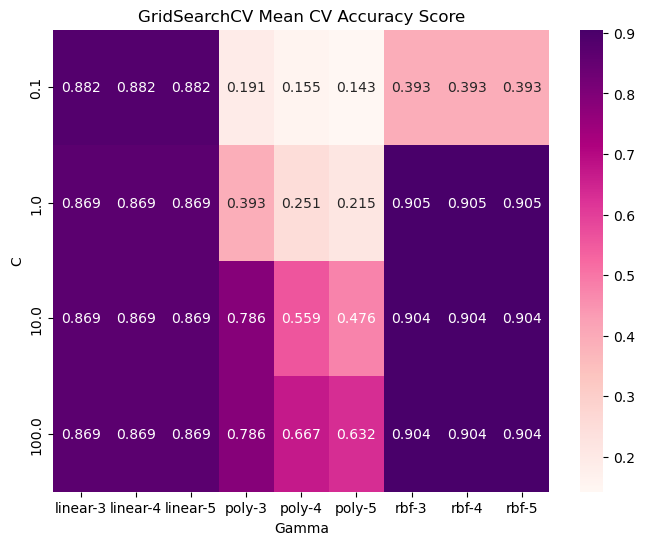

In [29]:
results = pd.DataFrame(grid_search.cv_results_)

pivot = results.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns=['param_kernel', 'param_degree']
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="RdPu")
plt.title("GridSearchCV Mean CV Accuracy Score")
plt.ylabel("C")
plt.xlabel("Gamma")
plt.show()

Here we verify that the best model is also the best model on our validation set. We notice that it's indeed the case!

In [41]:
from itertools import product
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [3, 4, 5]
}
results = []
for C, kernel, degree in product(param_grid['C'], param_grid['kernel'], param_grid['degree']):
    if kernel != 'poly' and degree != 3:
        continue
  
    clf = SVC(C=C, kernel=kernel, degree=degree)
    clf.fit(X_train_z, y_train)
    y_val_pred = clf.predict(X_val_z)
    #f1 = f1_score(y_val, y_val_pred, average='macro')
    accuracy = accuracy_score(y_val, y_val_pred)
  
    results.append({
        'C': C,
        'kernel': kernel,
        'degree': degree,
        #'val_f1': f1
        'val_accuracy': accuracy
    })
results_df = pd.DataFrame(results).sort_values(by='val_accuracy', ascending=False)
print(results_df.head(5))

        C  kernel  degree  val_accuracy
6     1.0     rbf       3      0.958333
0     0.1  linear       3      0.916667
16  100.0     rbf       3      0.916667
15  100.0  linear       3      0.916667
11   10.0     rbf       3      0.916667


In [42]:
# Train SVM classifier on the best hyperparameters from grid search:
clf = SVC(kernel='rbf', C=1)
clf.fit(X_train_z, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


[ 4 10  4  9 11 12  5  2  1  8  6  3  5  6 12  1  7 10  9  3 11  2 10  7]
[ 4 10  4  9 11 12  5  2  1  8  6  3  5  6 12  1  7 10  9  3 11  2  8  7]
Accuracy: 0.958
Precision: 0.972
Recall: 0.958
F1 score: 0.956


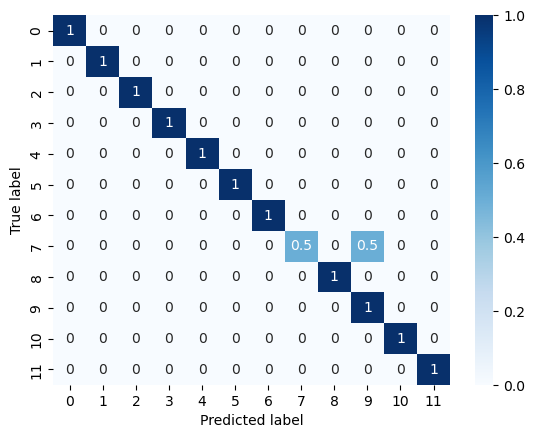

In [43]:
# Predict on validation set:

y_pred = clf.predict(X_val_z)

y_val = y_val.astype(int)
y_pred = y_pred.astype(int)

print(y_pred)
print(y_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro') 
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()


Accuracy: 0.833
Precision: 0.750
Recall: 0.833
F1 score: 0.778


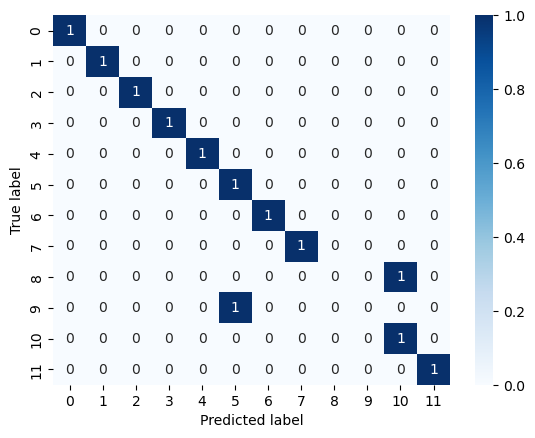

In [44]:
# Predict on test set:

y_pred_test = clf.predict(X_test_z)

y_pred_test = y_pred_test.astype(int)
y_test = y_test.astype(int)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro') 
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3}")
print(f"F1 score: {f1:.3f}")

confmat = confusion_matrix(y_test, y_pred_test, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax, cmap="Blues")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()


In [34]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.88235294 0.82352941 0.94117647 0.94117647 0.9375    ]
Mean accuracy across all models: 0.9051470588235293


## Feature selection

## RFE

In [35]:
from sklearn.feature_selection import RFE

def fit_and_evalute_RFE(n_features_to_select=10):
    svm_rfe = RFE(estimator=SVC(kernel='linear'), n_features_to_select=n_features_to_select, step=0.1)
    X_train_selected = svm_rfe.fit_transform(X_train_z, y_train)
    X_val_selected = svm_rfe.transform(X_val_z)
    X_test_selected = svm_rfe.transform(X_test_z)

    param_grid = {
         'C': [0.1, 1, 10, 100],            
         'kernel': ['linear', 'rbf', 'poly'], 
         'degree': [3, 4, 5]                     
        }       

    grid_search = GridSearchCV(
        SVC(),
        param_grid,
        scoring='accuracy',   
        cv=5,               
        n_jobs=-1,         
        verbose=1
    )
    
    grid_search.fit(X_train_selected, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print(f"Best cross-validation accuracy score: {grid_search.best_score_:.3f}")


    clf = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], degree=grid_search.best_params_['degree'])
    clf.fit(X_train_selected, y_train)

    #Evaluate on validation set
    y_val_pred = clf.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Validation Accuracy with {n_features_to_select} features: {accuracy:.3f}")
    print(f"Validation F1 Score with {n_features_to_select} features: {f1:.3f}")

    #Evaluate on test set
    y_test_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Test Accuracy with {n_features_to_select} features: {accuracy:.3f}")
    print(f"Test F1 Score with {n_features_to_select} features: {f1:.3f}")

In [36]:
n_features_to_select = [5, 10, 15, 20, 25, 30]
for n in n_features_to_select:
    print(f"\nEvaluating with top {n} features:")
    fit_and_evalute_RFE(n_features_to_select=n)


Evaluating with top 5 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.822
Validation Accuracy with 5 features: 0.750
Validation F1 Score with 5 features: 0.956
Test Accuracy with 5 features: 0.917
Test F1 Score with 5 features: 0.889

Evaluating with top 10 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 0.1, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.918
Validation Accuracy with 10 features: 0.750
Validation F1 Score with 10 features: 0.956
Test Accuracy with 10 features: 1.000
Test F1 Score with 10 features: 1.000

Evaluating with top 15 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}
Best cross-validation accuracy score: 0.941
Validation Accuracy with 15 features: 0.875
Validation F1 Score with 15 features:

## PCA

In [37]:
from sklearn.decomposition import PCA

def fit_and_evalute_PCA(n_components=10):

    pca = PCA(n_components= n_components) 
    X_train_selected = pca.fit_transform(X_train_z, y_train)

    print(f"Explained variance (cumulative): {np.cumsum(pca.explained_variance_ratio_)}")
    print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)}")
    X_val_selected = pca.transform(X_val_z)
    X_test_selected = pca.transform(X_test_z)

    param_grid = {
         'C': [0.1, 1, 10, 100],            
         'kernel': ['linear', 'rbf', 'poly'], 
         'degree': [3, 4, 5]                     
        }       

    grid_search = GridSearchCV(
        SVC(),
        param_grid,
        scoring='accuracy',   
        cv=5,               
        n_jobs=-1,         
        verbose=1
    )
    
    grid_search.fit(X_train_selected, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print(f"Best cross-validation accuracy score: {grid_search.best_score_:.3f}")


    clf = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], degree=grid_search.best_params_['degree'])
    clf.fit(X_train_selected, y_train)

    #Evaluate on validation set
    y_val_pred = clf.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Validation Accuracy with {n_components} features: {accuracy:.3f}")
    print(f"Validation F1 Score with {n_components} features: {f1:.3f}")

    #Evaluate on test set
    y_test_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Test Accuracy with {n_components} features: {accuracy:.3f}")
    print(f"Test F1 Score with {n_components} features: {f1:.3f}")

In [38]:
n_components_list = [5, 10, 15, 20, 25, 30]
for n in n_components_list:
    print(f"\nEvaluating with top {n} components:")
    fit_and_evalute_PCA(n_components=n)


Evaluating with top 5 components:
Explained variance (cumulative): [0.40387964 0.52673917 0.62328626 0.6850447  0.73939835]
Total explained variance: 0.7393983477741836
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.810
Validation Accuracy with 5 features: 0.792
Validation F1 Score with 5 features: 0.956
Test Accuracy with 5 features: 0.917
Test F1 Score with 5 features: 0.889

Evaluating with top 10 components:
Explained variance (cumulative): [0.40387964 0.52673917 0.62328626 0.6850447  0.73939835 0.78008474
 0.8114469  0.84006479 0.86599581 0.88749582]
Total explained variance: 0.8874958193871059
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 10, 'degree': 3, 'kernel': 'rbf'}
Best cross-validation accuracy score: 0.870
Validation Accuracy with 10 features: 0.917
Validation F1 Score with 10 features: 0.956
Test Accuracy with 10 featu

## Mutual info

In [39]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

def fit_and_evalute_MI(n_features=10):

    k_best = SelectKBest(mutual_info_classif, k=n_features)
    k_best.fit(X_train_z, y_train)
    X_train_selected = k_best.transform(X_train_z)
    X_val_selected = k_best.transform(X_val_z)
    X_test_selected = k_best.transform(X_test_z)

    param_grid = {
         'C': [0.1, 1, 10, 100],            
         'kernel': ['linear', 'rbf', 'poly'], 
         'degree': [3, 4, 5]                     
        }       

    grid_search = GridSearchCV(
        SVC(),
        param_grid,
        scoring='accuracy',   
        cv=5,               
        n_jobs=-1,         
        verbose=1
    )
    
    grid_search.fit(X_train_selected, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print(f"Best cross-validation accuracy score: {grid_search.best_score_:.3f}")


    clf = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], degree=grid_search.best_params_['degree'])
    clf.fit(X_train_selected, y_train)

    #Evaluate on validation set
    y_val_pred = clf.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Validation Accuracy with {n_features} features: {accuracy:.3f}")
    print(f"Validation F1 Score with {n_features} features: {f1:.3f}")

    #Evaluate on test set
    y_test_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Test Accuracy with {n_features} features: {accuracy:.3f}")
    print(f"Test F1 Score with {n_features} features: {f1:.3f}")

In [40]:
n_features_list = [5, 10, 15, 20, 25, 30]
for n in n_features_list:
    print(f"\nEvaluating with top {n} features:")
    fit_and_evalute_MI(n_features=n)


Evaluating with top 5 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 100, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.582
Validation Accuracy with 5 features: 0.500
Validation F1 Score with 5 features: 0.956
Test Accuracy with 5 features: 0.500
Test F1 Score with 5 features: 0.389

Evaluating with top 10 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 10, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.810
Validation Accuracy with 10 features: 0.833
Validation F1 Score with 10 features: 0.956
Test Accuracy with 10 features: 0.833
Test F1 Score with 10 features: 0.778

Evaluating with top 15 features:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 100, 'degree': 3, 'kernel': 'linear'}
Best cross-validation accuracy score: 0.810
Validation Accuracy with 15 features: 0.875
Validation F1 Score with 15 fea